In [3]:
# 1. Установка Kaggle API
!pip install -q kaggle

# 2. Загрузка вашего kaggle (2).json
from google.colab import files
uploaded = files.upload()  # Нажмите "Выбрать файл" и загрузите kaggle (2).json

# 3. Перемещение и переименование файла API (чтобы Kaggle его увидел)
!mkdir -p ~/.kaggle
!mv 'kaggle (2).json' ~/.kaggle/kaggle.json  # Важно: переименовываем в kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Даем нужные права

# 4. Проверка, что API работает (опционально)
!kaggle datasets list -s "airbnb"  # Ищем датасет

# 5. Скачивание нужного датасета (joebeachcapital/airbnb)
!kaggle datasets download -d joebeachcapital/airbnb

# 6. Распаковка (если скачался ZIP)
!unzip -q airbnb.zip  # Или другое название файла, если отличается

Saving kaggle (2).json to kaggle (2).json
ref                                                       title                                            size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
airbnb/seattle                                            Seattle Airbnb Open Data                     20410379  2018-06-26 04:29:12.570000          43905        429  0.7058824        
airbnb/boston                                             Boston Airbnb Open Data                      16893659  2019-11-17 21:30:47.763000          23041        221  0.7058824        
arianazmoudeh/airbnbopendata                              Airbnb Open Data                             10964528  2022-08-01 15:58:10.983000          44172        342  1.0              
dgomonov/new-york-city-airbnb-ope

Датасет: Airbnb Global Listings https://www.kaggle.com/datasets/joebeachcapital/airbnb

Цели нашей работы:
* Разведочный анализ данных (EDA) для понимания структуры и распределений

* Статистический анализ ключевых признаков

* Построение и оценка моделей для прогнозирования цены



В данном проекте проводится исследование датасета Airbnb с целью выявления факторов, влияющих на успешность размещений. Под успешностью понимается популярность объекта — например, высокая частота бронирований, большое количество отзывов или высокий средний рейтинг. Задача заключается в том, чтобы определить, какие характеристики объявления — такие как цена, расположение, тип жилья, наличие удобств или политика отмены — способствуют его привлекательности для гостей.

Исследование начинается с разведочного анализа данных (EDA), включающего оценку структуры датасета, выявление пропусков и выбросов, а также изучение распределений признаков. Особое внимание уделяется целевой переменной, отражающей успешность объекта размещения — это может быть, например, число отзывов в месяц или общий рейтинг. Изучаются как числовые, так и категориальные признаки, проводится анализ взаимосвязей между переменными, формулируются гипотезы о влиянии различных факторов.

На следующем этапе строятся модели машинного обучения, способные прогнозировать успешность жилья. В рамках работы используются три алгоритма классификации: логистическая регрессия, метод k-ближайших соседей (kNN) и случайный лес. Модели обучаются на основе отобранных признаков, включающих цену, расположение, тип жилья, оценки гостей, набор удобств, а также параметры, связанные с хозяином.

Для оценки качества моделей применяются такие метрики, как точность, полнота, F1-мера и ROC-AUC. Это позволяет объективно сравнить эффективность различных алгоритмов и выбрать наилучший вариант.

Предварительные гипотезы исследования заключаются в том, что такие факторы, как разумная цена, положительные отзывы, удачное местоположение и широкий набор удобств, положительно влияют на популярность объявления. Также предполагается, что опыт и активность хоста, гибкие условия отмены и невысокие требования к минимальному сроку аренды могут способствовать увеличению спроса.

Ожидаемый результат работы — выделение наиболее значимых факторов, определяющих успешность размещения, а также построение моделей, способных предсказывать популярность объектов на платформе Airbnb. Выводы будут подтверждены наглядными визуализациями, иллюстрирующими ключевые зависимости и важность признаков.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import pointbiserialr, f_oneway

In [5]:
df = pd.read_csv('airbnb-listings.csv', sep=';')

df.head()

<ipython-input-5-5c98af442252>:1: DtypeWarning: Columns (0,2,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('airbnb-listings.csv', sep=';')


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,4008728,https://www.airbnb.com/rooms/4008728,20170402075052,2017-04-02,"Luxurious 3 bedroom, centrum, 180m2",‪This luxurious apartment is situated in the c...,In the heart of hip & lively Amsterdam Centrum...,‪This luxurious apartment is situated in the c...,none,There is a wide variety of cafes and restauran...,...,10.0,10.0,9.0,NaN,Amsterdam,strict,1.0,1.52,"52.36523660409065, 4.878249575101092","Host Has Profile Pic,Host Identity Verified,Is..."
1,7778612,https://www.airbnb.com/rooms/7778612,20170402075052,2017-04-02,Luxury apartment in city centre,"Beautiful, large (105m2, 2 floors) and quiet a...",1 living room 1 dining room 2 bedrooms 1 bathr...,"Beautiful, large (105m2, 2 floors) and quiet a...",none,Within a few minutes walking you'll be in the ...,...,10.0,10.0,9.0,NaN,Amsterdam,strict,1.0,0.81,"52.367309030897516, 4.8738407410699915","Host Is Superhost,Host Has Profile Pic,Host Id..."
2,8264596,https://www.airbnb.com/rooms/8264596,20170402075052,2017-04-02,Cosy apartment across Vondelpark,This central located apartment will make you f...,NaN,This central located apartment will make you f...,none,NaN,...,10.0,10.0,10.0,NaN,Amsterdam,flexible,1.0,0.05,"52.361943953804776, 4.866686522141489","Host Has Profile Pic,Host Identity Verified,Is..."
3,2180729,https://www.airbnb.com/rooms/2180729,20170402075052,2017-04-02,Spacious City Apartment Oud-West,Living like an Amsterdam resident in this ligh...,There are 2 bedrooms each with a double bed. I...,Living like an Amsterdam resident in this ligh...,none,The 85 m2 apartment is located on a quiet stre...,...,9.0,9.0,9.0,NaN,Amsterdam,flexible,1.0,0.62,"52.37014616115532, 4.866281767968382","Host Has Profile Pic,Host Identity Verified,Is..."
4,14463171,https://www.airbnb.com/rooms/14463171,20170402075052,2017-04-02,Cosy Studio Apartment Center Amsterdam,Studio Apartment Centre Amsterdam Perfect stud...,NaN,Studio Apartment Centre Amsterdam Perfect stud...,none,NaN,...,8.0,9.0,9.0,NaN,Amsterdam,moderate,1.0,2.04,"52.368817829014425, 4.871249476925455",Host Has Profile Pic


Проанализиурем признаки на предмет корреляции с целевым признаком (ценой)

Почистим данные и выберем ключевые признаки:


In [7]:
item0 = df.shape[0]
df = df.drop_duplicates()
item1 = df.shape[0]
print(f"There are {item0-item1} duplicates found in the dataset")

df = df[df['Price']>0]

replacement_dict = {'Αθήνα, Greece': 'Athens, Greece',
                    'Athina, Greece': 'Athens, Greece',
                    'Roma, Italy': 'Rome, Italy',
                    'Venezia, Italy': 'Venice, Italy',
                    'København, Denmark': 'Copenhagen, Denmark',
                    'Montréal, Canada': 'Montreal, Canada',
                    'Ville de Québec, Canada': 'Québec, Canada',
                    'Genève, Switzerland': 'Geneva, Switzerland',
                    'Palma, Spain': 'Palma de Mallorca, Spain',
                    'Wien, Austria': 'Vienna, Austria',
                    'Greater London, United Kingdom': 'London, United Kingdom'
                   }
df['Smart Location'] = df['Smart Location'].replace(replacement_dict).fillna('None').astype(str)

selected_cols = ['Price', 'Smart Location', 'Room Type', 'Property Type', 'Bed Type', 'Availability 365', 'Minimum Nights',
                 'Number of Reviews', 'Review Scores Rating', 'Cancellation Policy']
df = df[selected_cols]
print(df.shape)
df.sample(5).T

There are 0 duplicates found in the dataset
(486974, 10)


,452755,138352,70773,80592,146825
Price,85.0,68.0,125.0,38.0,100.0
Smart Location,"Paris, France","Paris, France","New York, NY","Paris, France","Rome, Italy"
Room Type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
Property Type,Apartment,Apartment,Apartment,Apartment,Apartment
Bed Type,Pull-out Sofa,Real Bed,Real Bed,Real Bed,Real Bed
Availability 365,259.0,0.0,0.0,42.0,322.0
Minimum Nights,3.0,2.0,2.0,5.0,3.0
Number of Reviews,41.0,14.0,12.0,5.0,33.0
Review Scores Rating,95.0,99.0,92.0,96.0,93.0
Cancellation Policy,moderate,moderate,strict,flexible,strict_new


In [ ]:
text_cols = ['Room Type', 'Property Type', 'Bed Type', 'Cancellation Policy']
for col in text_cols:
    df[col] = df[col].fillna('Unknown').str.strip().str.title()

num_cols = ['Availability 365', 'Minimum Nights', 'Number of Reviews', 'Review Scores Rating']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

price_threshold = df['Price'].quantile(0.99)
df = df[df['Price'] <= price_threshold]

df = df[
    (df['Availability 365'] >= 0) &
    (df['Availability 365'] <= 365) &
    (df['Minimum Nights'] > 0) &
    (df['Review Scores Rating'] >= 0) &
    (df['Review Scores Rating'] <= 100)
].reset_index(drop=True)

print("\nСтатистика после очистки:")
print(f"Осталось записей: {df.shape[0]}")
print(f"Пропущенных значений:\n{df.isna().sum()}")

print("\nПроверка выбросов:")
print(df[['Price', 'Availability 365', 'Minimum Nights']].describe())

display(df.sample(5).T)


Статистика после очистки:
Осталось записей: 482322
Пропущенных значений:
Price                   0
Smart Location          0
Room Type               0
Property Type           0
Bed Type                0
Availability 365        0
Minimum Nights          0
Number of Reviews       0
Review Scores Rating    0
Cancellation Policy     0
dtype: int64

Проверка выбросов:
               Price  Availability 365  Minimum Nights
count  482322.000000     482322.000000   482322.000000
mean      130.720036        166.386093        3.469717
std       130.074250        140.351437       90.531430
min         1.000000          0.000000        1.000000
25%        55.000000         15.000000        1.000000
50%        90.000000        149.000000        2.000000
75%       150.000000        313.000000        3.000000
max       801.000000        365.000000    60000.000000


,240337,187522,203639,12749,337946
Price,175.0,75.0,103.0,65.0,60.0
Smart Location,"Venice, CA","Dorval, Canada","Barcelona, Spain","Los Angeles, CA","Palmanova, Spain"
Room Type,Private Room,Private Room,Entire Home/Apt,Shared Room,Entire Home/Apt
Property Type,Apartment,House,Apartment,Apartment,Apartment
Bed Type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
Availability 365,0.0,236.0,197.0,360.0,365.0
Minimum Nights,1.0,1.0,2.0,1.0,1.0
Number of Reviews,2.0,13.0,37.0,0.0,1.0
Review Scores Rating,100.0,100.0,89.0,95.0,80.0
Cancellation Policy,Flexible,Flexible,Moderate,Flexible,Flexible


In [8]:
cols_to_clean = ['Room Type', 'Property Type', 'Bed Type', 'Cancellation Policy', 'Smart Location']

for col in cols_to_clean:
    if col in df.columns:

        df.drop(df[(df[col] == 'Unknown') | (df[col] == '9')].index, inplace=True)

        df.reset_index(drop=True, inplace=True)

Рассмотрим распределени ключевых признаков:

<ipython-input-13-405e77c75de0>:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


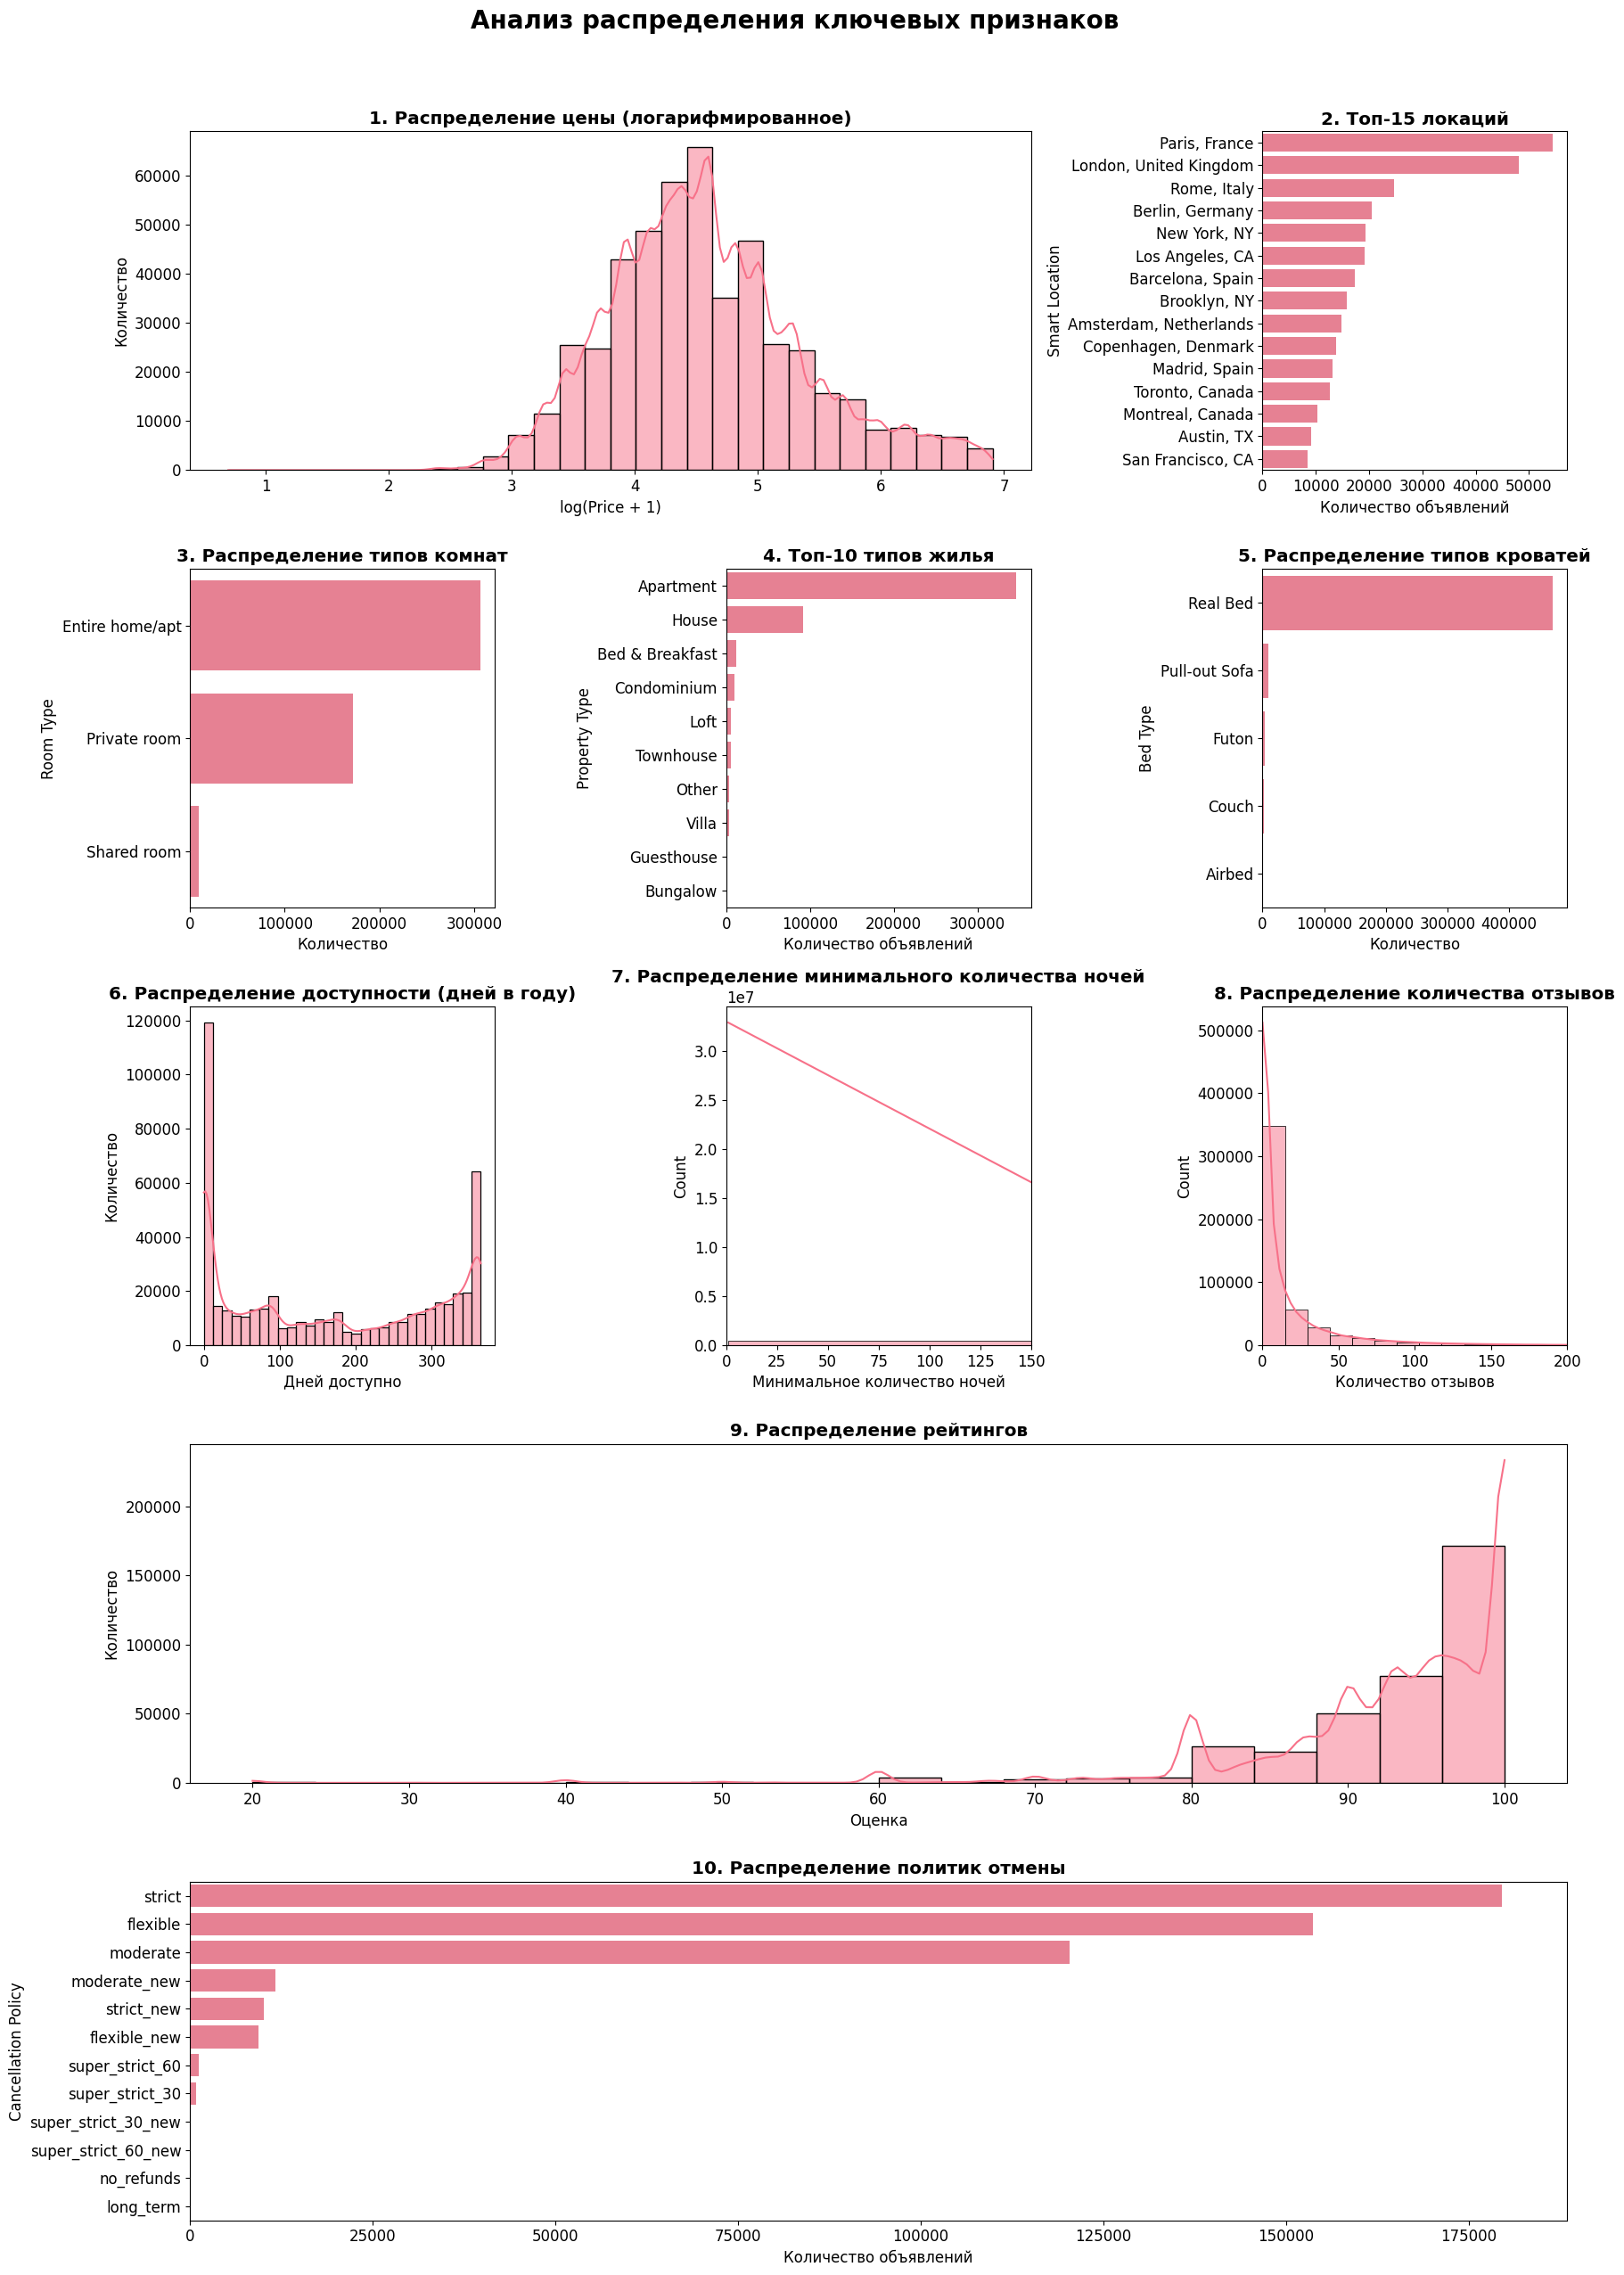

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 18)
plt.rcParams['font.size'] = 12

selected_cols = ['Price', 'Smart Location', 'Room Type', 'Property Type', 'Bed Type',
                'Availability 365', 'Minimum Nights', 'Number of Reviews',
                'Review Scores Rating', 'Cancellation Policy']

fig = plt.figure(constrained_layout=True, figsize=(18, 25))
gs = fig.add_gridspec(5, 3)

# 1. Распределение цены
ax1 = fig.add_subplot(gs[0, :2])
sns.histplot(np.log1p(df['Price']), bins=30, kde=True, ax=ax1)
ax1.set_title('1. Распределение цены (логарифмированное)', fontweight='bold')
ax1.set_xlabel('log(Price + 1)')
ax1.set_ylabel('Количество')

# 2. Топ-15 локаций
ax2 = fig.add_subplot(gs[0, 2])
top_locations = df['Smart Location'].value_counts().head(15)
sns.barplot(x=top_locations.values, y=top_locations.index, ax=ax2)
ax2.set_title('2. Топ-15 локаций', fontweight='bold')
ax2.set_xlabel('Количество объявлений')

# 3. Распределение типов комнат
ax3 = fig.add_subplot(gs[1, 0])
sns.countplot(y='Room Type', data=df, order=df['Room Type'].value_counts().index, ax=ax3)
ax3.set_title('3. Распределение типов комнат', fontweight='bold')
ax3.set_xlabel('Количество')

# 4. Топ-10 типов жилья
ax4 = fig.add_subplot(gs[1, 1])
top_properties = df['Property Type'].value_counts().head(10)
sns.barplot(x=top_properties.values, y=top_properties.index, ax=ax4)
ax4.set_title('4. Топ-10 типов жилья', fontweight='bold')
ax4.set_xlabel('Количество объявлений')

# 5. Распределение типов кроватей
ax5 = fig.add_subplot(gs[1, 2])
sns.countplot(y='Bed Type', data=df, order=df['Bed Type'].value_counts().index, ax=ax5)
ax5.set_title('5. Распределение типов кроватей', fontweight='bold')
ax5.set_xlabel('Количество')

# 6. Распределение доступности
ax6 = fig.add_subplot(gs[2, 0])
sns.histplot(df['Availability 365'], bins=30, kde=True, ax=ax6)
ax6.set_title('6. Распределение доступности (дней в году)', fontweight='bold')
ax6.set_xlabel('Дней доступно')
ax6.set_ylabel('Количество')

# 7. Распределение минимального количества ночей
ax7 = fig.add_subplot(gs[2, 1])
sns.histplot(df['Minimum Nights'], bins=50, kde=True, ax=ax7)
ax7.set_title('7. Распределение минимального количества ночей', fontweight='bold')
ax7.set_xlabel('Минимальное количество ночей')
ax7.set_xlim(0, 150)

# 8. Распределение количества отзывов
ax8 = fig.add_subplot(gs[2, 2])
sns.histplot(df['Number of Reviews'], bins=50, kde=True, ax=ax8)
ax8.set_title('8. Распределение количества отзывов', fontweight='bold')
ax8.set_xlabel('Количество отзывов')
ax8.set_ylabel('Частота')
ax8.set_xlim(0, 200)

# 9. Распределение рейтингов
ax9 = fig.add_subplot(gs[3, :])
sns.histplot(df['Review Scores Rating'].dropna(), bins=20, kde=True, ax=ax9)
ax9.set_title('9. Распределение рейтингов', fontweight='bold')
ax9.set_xlabel('Оценка')
ax9.set_ylabel('Количество')

# 10. Политики отмены
ax10 = fig.add_subplot(gs[4, :])
policy_order = df['Cancellation Policy'].value_counts().index
sns.countplot(y='Cancellation Policy', data=df, order=policy_order, ax=ax10)
ax10.set_title('10. Распределение политик отмены', fontweight='bold')
ax10.set_xlabel('Количество объявлений')

plt.suptitle('Анализ распределения ключевых признаков', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

Доступные числовые столбцы: ['Price', 'Availability 365', 'Minimum Nights', 'Number of Reviews', 'Review Scores Rating']


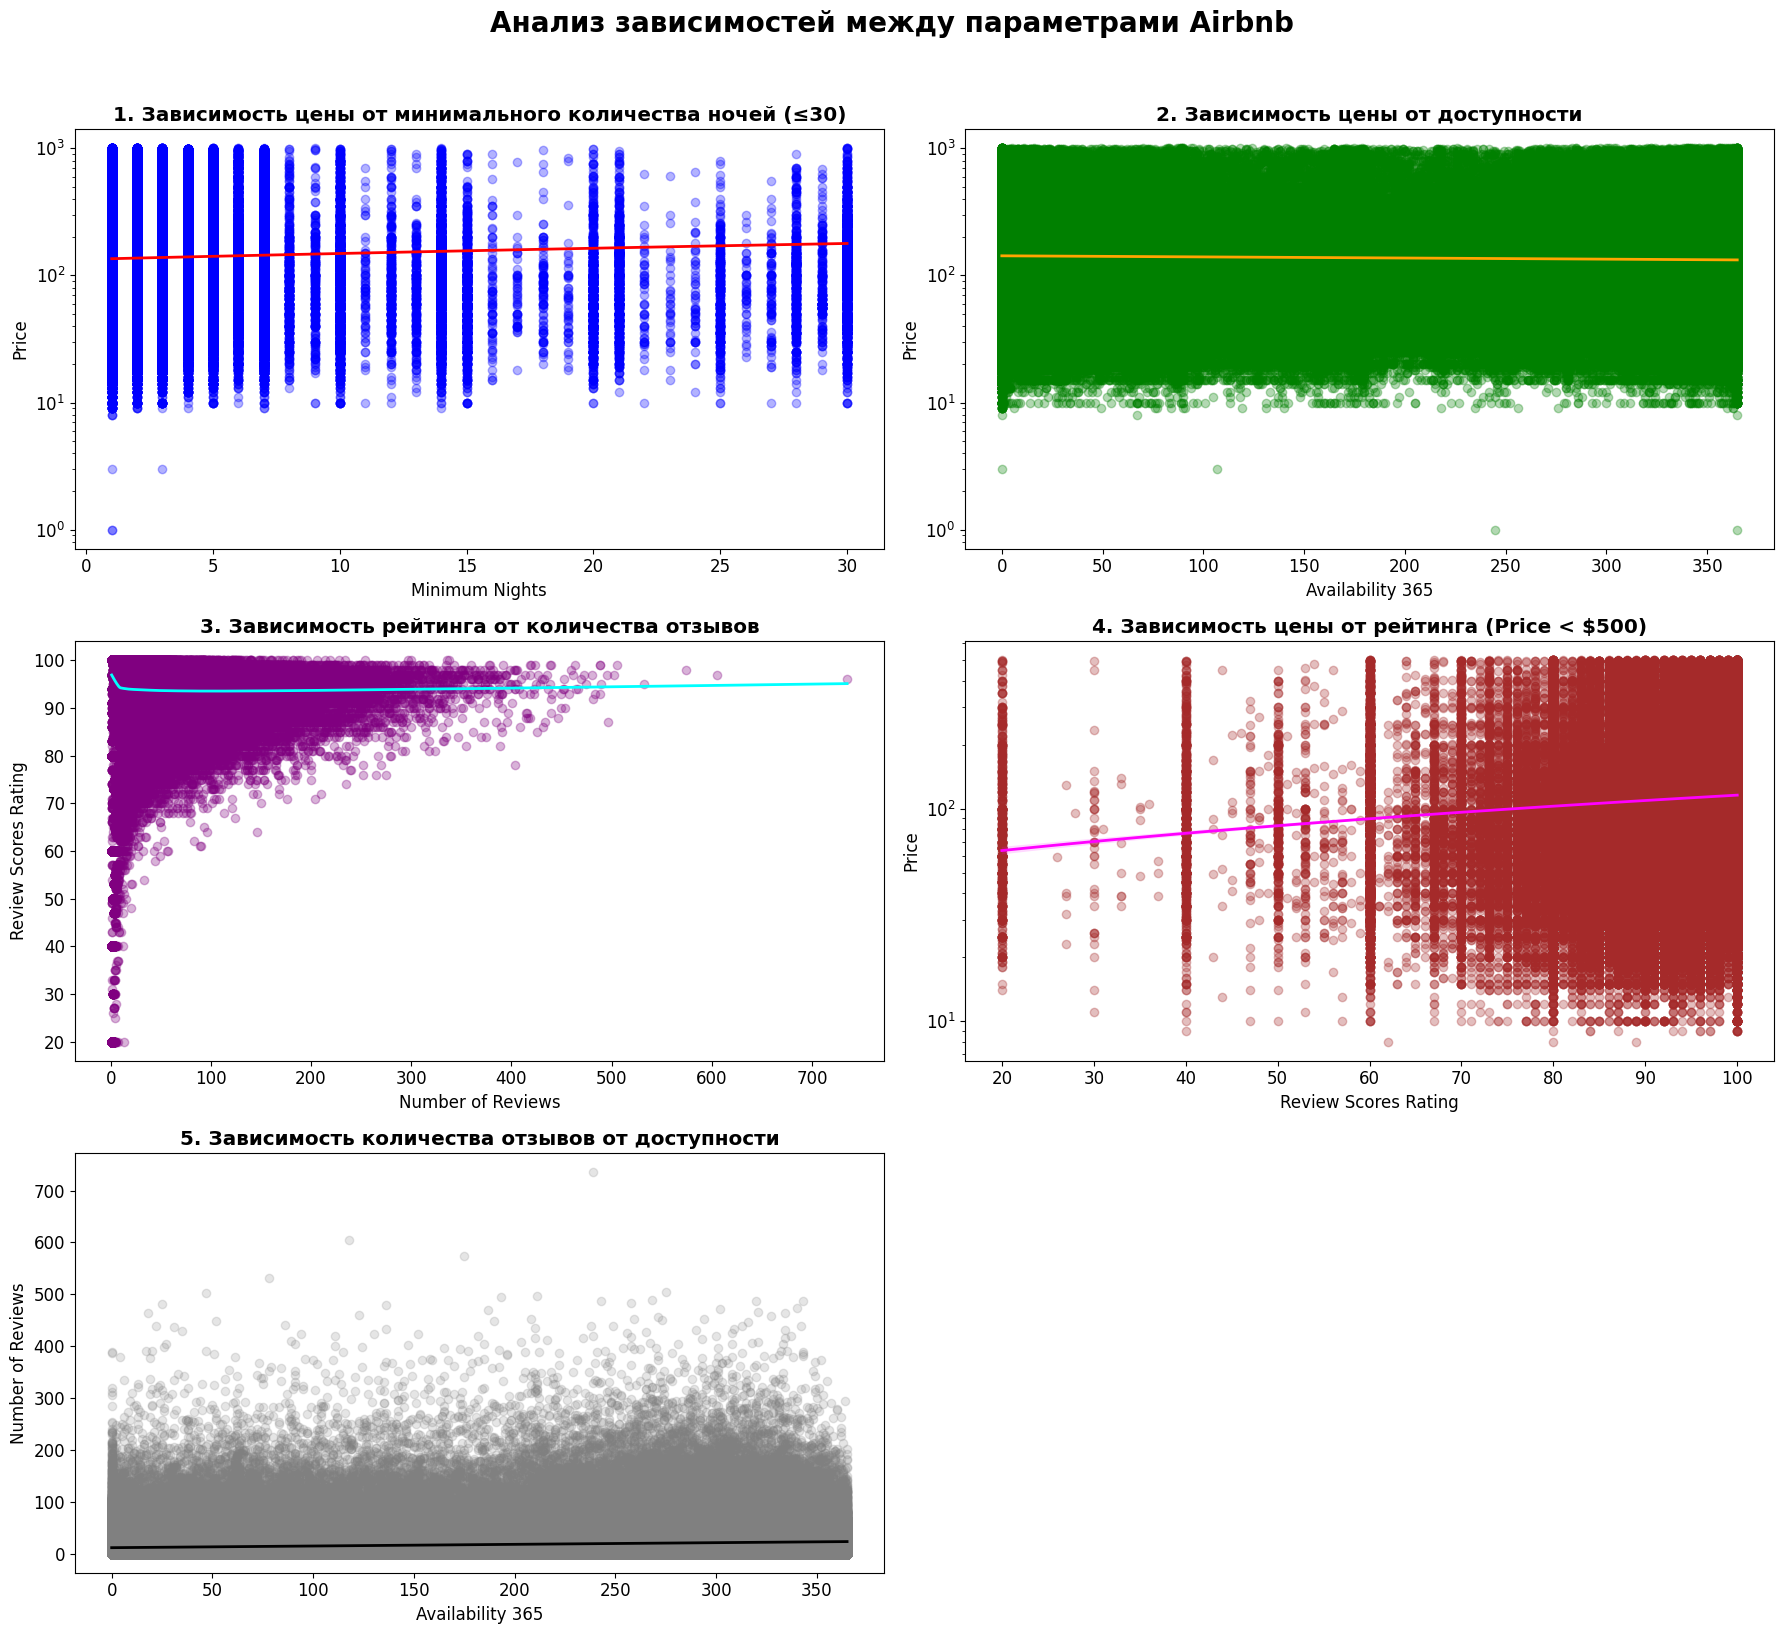

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Проверим какие числовые столбцы есть в данных
print("Доступные числовые столбцы:", df.select_dtypes(include=np.number).columns.tolist())

sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 16)
plt.rcParams['font.size'] = 12

# Создаем grid для графиков
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 1. Зависимость цены от минимального количества ночей
sns.regplot(x='Minimum Nights', y='Price', data=df[df['Minimum Nights'] <= 30],  # Фильтр выбросов
            scatter_kws={'alpha':0.3, 'color':'blue'},
            line_kws={'color':'red', 'lw':2},
            ax=axes[0,0])
axes[0,0].set_title('1. Зависимость цены от минимального количества ночей (≤30)', fontweight='bold')
axes[0,0].set_yscale('log')

# 2. Зависимость цены от доступности
sns.regplot(x='Availability 365', y='Price', data=df,
            scatter_kws={'alpha':0.3, 'color':'green'},
            line_kws={'color':'orange', 'lw':2},
            ax=axes[0,1])
axes[0,1].set_title('2. Зависимость цены от доступности', fontweight='bold')
axes[0,1].set_yscale('log')

# 3. Зависимость рейтинга от количества отзывов
sns.regplot(x='Number of Reviews', y='Review Scores Rating', data=df,
            scatter_kws={'alpha':0.3, 'color':'purple'},
            line_kws={'color':'cyan', 'lw':2},
            lowess=True,  # Нелинейная регрессия
            ax=axes[1,0])
axes[1,0].set_title('3. Зависимость рейтинга от количества отзывов', fontweight='bold')

# 4. Зависимость цены от рейтинга
sns.regplot(x='Review Scores Rating', y='Price', data=df[df['Price'] < 500],  # Фильтр выбросов
            scatter_kws={'alpha':0.3, 'color':'brown'},
            line_kws={'color':'magenta', 'lw':2},
            ax=axes[1,1])
axes[1,1].set_title('4. Зависимость цены от рейтинга (Price < $500)', fontweight='bold')
axes[1,1].set_yscale('log')

# 5. Зависимость количества отзывов от доступности
sns.regplot(x='Availability 365', y='Number of Reviews', data=df,
            scatter_kws={'alpha':0.2, 'color':'gray'},
            line_kws={'color':'black', 'lw':2},
            ax=axes[2,0])
axes[2,0].set_title('5. Зависимость количества отзывов от доступности', fontweight='bold')

# 6. Оставляем пустым или добавляем другой график
axes[2,1].axis('off')  # Скрываем последний subplot

plt.suptitle('Анализ зависимостей между параметрами Airbnb', y=1.02, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()